#            Predicting aqua solubility in data mining

This project aims to predict how easily chemicals dissolve, which is essential for creating effective medicines. We're using a dataset with varied chemical characteristics for a thorough study. Our process includes standardizing the data, creating new features from the existing data, and trying different predictive models. The goal is to find a reliable way to predict chemical solubility faster than traditional lab tests.

## Preprocessing and Exploratory Data Analysis


In [50]:
import pandas as pd
import numpy as np
from scipy import stats
import seaborn as sns
import matplotlib.pyplot as plt
import os
from sklearn.feature_selection import mutual_info_classif
from IPython.display import display
from sklearn.model_selection import cross_val_score
from sklearn.metrics import mean_squared_error
from sklearn.neural_network import MLPRegressor
from sklearn.model_selection import cross_val_score, KFold
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from sklearn.feature_selection import mutual_info_regression
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, r2_score
from mpl_toolkits.mplot3d import Axes3D
import matplotlib.patches as mpatches
import statsmodels.api as sm
import matplotlib.pyplot as plt
from statsmodels.stats.diagnostic import het_goldfeldquandt, het_breuschpagan, het_white
from statsmodels.stats.stattools import durbin_watson
from scipy.stats import shapiro
from statsmodels.stats.outliers_influence import variance_inflation_factor
from statsmodels.tools.tools import add_constant


### Data Information

In [51]:
# Load the dataset
dataset_path = 'data/data.csv'
data = pd.read_csv(dataset_path)
target_col = 'logS'

In [52]:
# File and parameters loading
problem_type = 'regression'
data_size = 'small'

In [53]:
print('Number of instances = %d' % (data.shape[0]))
print('Number of attributes = %d' % (data.shape[1]))
data.head()

Number of instances = 1144
Number of attributes = 5


,MolLogP,MolWt,NumRotatableBonds,AromaticProportion,logS
0,2.5954,167.850,0.0,0.0,-2.18
1,2.3765,133.405,0.0,0.0,-2.00
2,2.5938,167.850,1.0,0.0,-1.74
3,2.0289,133.405,1.0,0.0,-1.48
4,2.9189,187.375,1.0,0.0,-3.04


##### Data Types

In [54]:
# Print data types of DataFrame
data.dtypes

MolLogP               float64
MolWt                 float64
NumRotatableBonds     float64
AromaticProportion    float64
logS                  float64
dtype: object

The dataset contains the following attributes, each representing a specific chemical property:

**MolLogP**: Represents the octanol-water partition coefficient, a measure of the distribution of a compound between water and octanol. It's used to predict the lipophilicity of the compound.

**MolWt**: Molecular Weight. This is the weight of a molecule based on the atomic masses of its constituent atoms. It's a fundamental property impacting a compound's behavior and reactivity.

**NumRotatableBonds**: Number of Rotatable Bonds. This attribute indicates the number of bonds that allow for free rotation around themselves. More rotatable bonds generally mean more flexibility of the molecule.

**AromaticProportion**: The proportion of a molecule that is aromatic. This is a ratio of the number of aromatic atoms to the total number of heavy atoms (non-hydrogen atoms). Aromatic compounds are those that contain benzene-like rings.

**logS**: The logarithm of the compound's solubility in water. This is the target variable being predicted. Solubility is a key factor in a drug's absorption and distribution characteristics.

In [55]:
def plot_dataframe_datatypes_small_circle(df):
    datatype_counts = df.dtypes.value_counts()
    plt.figure(figsize=(3, 3))
    plt.pie(datatype_counts, labels=datatype_counts.index.astype(str), autopct='%1.1f%%', startangle=140)
    plt.axis('equal')
    plt.title('Data Type Distribution')
    plt.show()

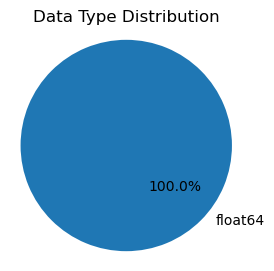

In [56]:
plot_dataframe_datatypes_small_circle(data)

##### Dataframe Statistics

In [57]:
# Print description of DataFrame
data.describe().T

,count,mean,std,min,25%,50%,75%,max
MolLogP,1144.0,2.449133,1.866003,-7.5714,1.41490,2.3403,3.406475,10.3886
MolWt,1144.0,204.631675,102.620500,16.0430,122.12600,183.5945,270.715750,780.9490
NumRotatableBonds,1144.0,2.173951,2.627398,0.0000,0.00000,1.0000,3.000000,23.0000
AromaticProportion,1144.0,0.364932,0.343305,0.0000,0.00000,0.3750,0.666667,1.0000
logS,1144.0,-3.057997,2.096502,-11.6000,-4.33225,-2.8705,-1.600000,1.5800


##### Which columns could be categorical ?

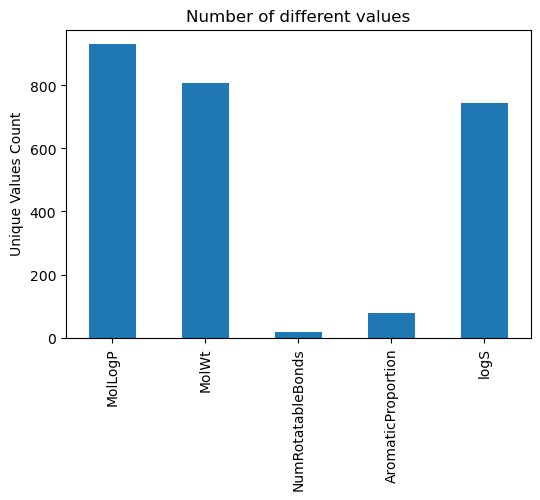

In [58]:
# Calculating the number of unique values for each column
unique_values = data.apply(lambda x: x.nunique())

# Creating the histogram
plt.figure(figsize=(6, 4))
unique_values.plot(kind='bar')
plt.title('Number of different values')
plt.ylabel('Unique Values Count')
plt.show()

#### Observations and Inferences

The bar chart displays the count of unique values for each feature in a dataset. MolLogP and logS have a high number of unique values, suggesting they are continuous variables with a wide range of measurements, which can provide rich information for modeling. In contrast, NumRotatableBonds and AromaticProportion have fewer unique values, indicating they might be discrete variables or have a limited range of values, potentially offering less granularity.

### Dataset Cleaning 


#### Missing Values


In [59]:
# Print number of missing values
data.isna().sum()

MolLogP               0
MolWt                 0
NumRotatableBonds     0
AromaticProportion    0
logS                  0
dtype: int64

This suggests that there are no missing values in the data.

#### Duplicate Data


In [60]:
print('Number of duplicate rows = %d' % (data.duplicated().sum()))
# Find the duplicates
duplicates = data[data.duplicated()]
duplicates

Number of duplicate rows = 15


,MolLogP,MolWt,NumRotatableBonds,AromaticProportion,logS
179,1.69844,107.156,0.0,0.750000,0.380
192,3.60230,207.070,0.0,0.909091,-4.400
310,2.04560,128.558,0.0,0.750000,-0.700
345,2.93590,142.242,6.0,0.000000,-2.580
568,3.87820,393.854,8.0,0.260870,-6.340
649,2.05760,286.349,4.0,0.315789,-3.420
896,1.40080,124.139,1.0,0.666667,-1.960
911,5.92900,320.046,3.0,0.666667,-7.200
912,6.18790,318.030,2.0,0.666667,-6.900
916,2.51800,184.242,1.0,0.857143,-2.700


In [61]:
print('Number of rows before discarding duplicates = %d' % (data.shape[0]))
data = data.drop_duplicates()
print('Number of rows after discarding duplicates = %d' % (data.shape[0]))

Number of rows before discarding duplicates = 1144
Number of rows after discarding duplicates = 1129


#### Standardization and Discarding Outliers

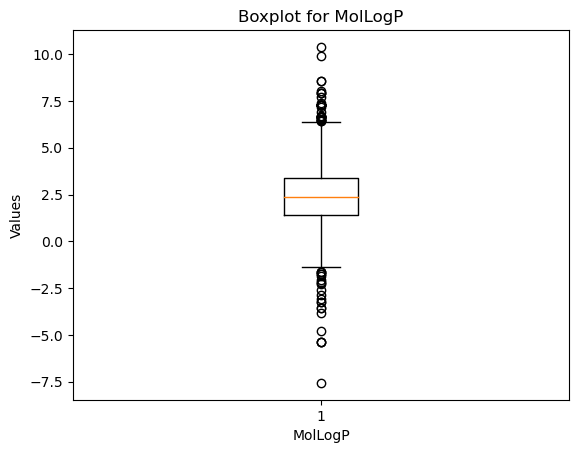

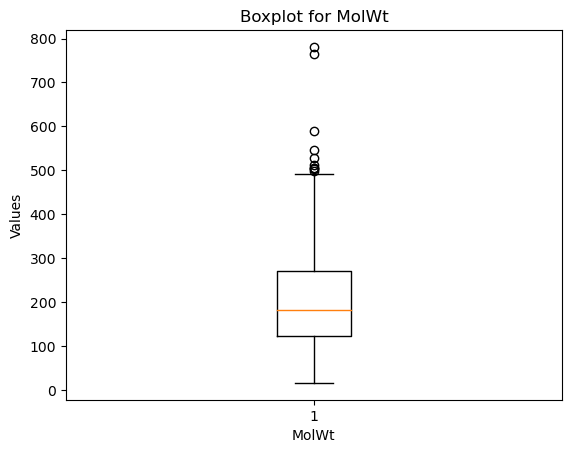

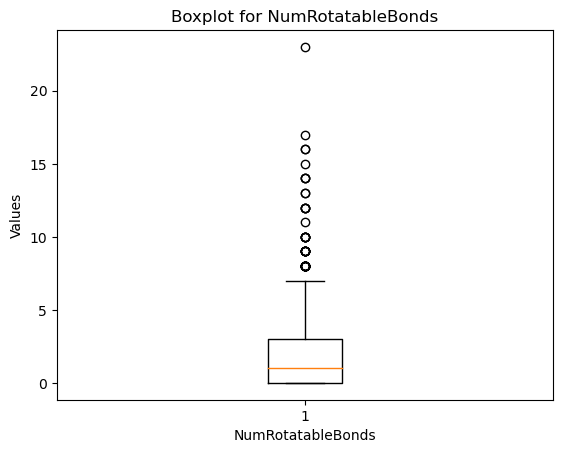

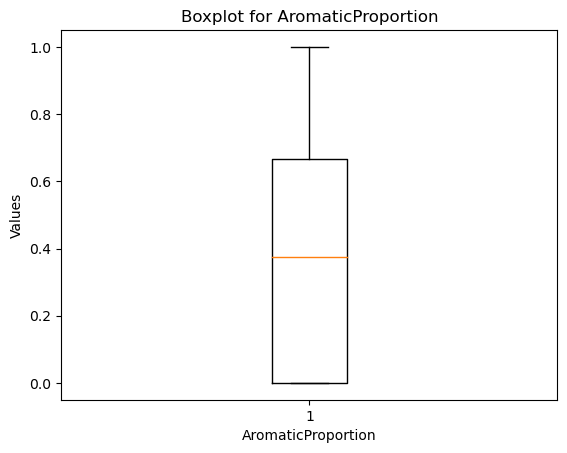

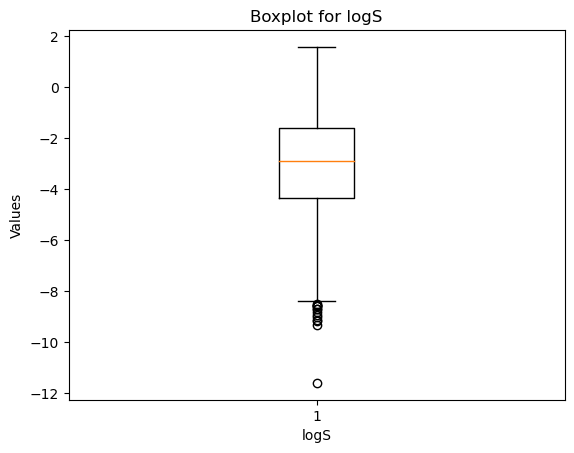

In [62]:
# Boxplot for 'MolLogP'
fig = plt.figure()
plt.boxplot(data['MolLogP'])
plt.xlabel('MolLogP')  # Add x-axis label
plt.ylabel('Values')   # Add y-axis label
plt.title('Boxplot for MolLogP')  # Add a title
plt.show()

# Boxplot for 'MolWt'
fig = plt.figure()
plt.boxplot(data['MolWt'])
plt.xlabel('MolWt')    # Add x-axis label
plt.ylabel('Values')   # Add y-axis label
plt.title('Boxplot for MolWt')   # Add a title
plt.show()

# Boxplot for 'NumRotatableBonds'
fig = plt.figure()
plt.boxplot(data['NumRotatableBonds'])
plt.xlabel('NumRotatableBonds')  # Add x-axis label
plt.ylabel('Values')   # Add y-axis label
plt.title('Boxplot for NumRotatableBonds')  # Add a title
plt.show()

# Boxplot for 'AromaticProportion'
fig = plt.figure()
plt.boxplot(data['AromaticProportion'])
plt.xlabel('AromaticProportion')  # Add x-axis label
plt.ylabel('Values')   # Add y-axis label
plt.title('Boxplot for AromaticProportion')  # Add a title
plt.show()

# Boxplot for 'logS'
fig = plt.figure()
plt.boxplot(data['logS'])
plt.xlabel('logS')      # Add x-axis label
plt.ylabel('Values')   # Add y-axis label
plt.title('Boxplot for logS')   # Add a title
plt.show()

The boxplots suggest that:
- the column (MolLogP) contains abnormally high and low values.
- the 2 columns (MolWt, NumRotatableBonds) contain abnormally high values. 
- the column (logS) contains abnormally low values.

To discard the outliers, we can compute the Z-score for each attribute and remove those instances containing attributes with abnormally high or low Z-score (e.g., if Z > 3 or Z <= -3).

In [63]:
Z = (data-data.mean())/data.std()
Z[20:25]

,MolLogP,MolWt,NumRotatableBonds,AromaticProportion,logS
20,0.408319,0.304805,-0.826556,1.127563,-0.209747
21,-0.360149,-0.163766,-0.446596,-1.058433,0.660765
22,0.291501,-0.562252,-0.826556,1.127563,0.005489
23,-0.527291,-1.030823,-0.446596,-1.058433,0.957314
24,-0.319301,-0.894018,-0.446596,-1.058433,0.699030


#### Observations and Inferences

In [64]:
def discard_outliers(Z, lower_threshold=-3, upper_threshold=3):
    """
    Discard outliers from a dataframe based on Z-scores.

    Parameters
    ----------
    Z: Pandas dataframe
        The dataframe containing the data.
    lower_threshold: float, optional
        The lower Z-score threshold (default is -3).
    upper_threshold: float, optional
        The upper Z-score threshold (default is 3).

    Returns
    -------
    Z2: Pandas dataframe
        The dataframe after discarding outliers.
    """
    num_rows_before = Z.shape[0]

    # Apply filtering conditions
    Z2 = Z.loc[(((Z > lower_threshold) & (Z <= upper_threshold)).all(axis=1))]
    
    num_rows_after = Z2.shape[0]
    print('Number of rows before discarding outliers = %d' % num_rows_before)
    print('Number of rows after discarding outliers = %d' % num_rows_after)

    return Z2


In [65]:
data = discard_outliers(Z)

Number of rows before discarding outliers = 1129
Number of rows after discarding outliers = 1096


### Plottings

#### Distribution of Individual Features: Insights from Visualization


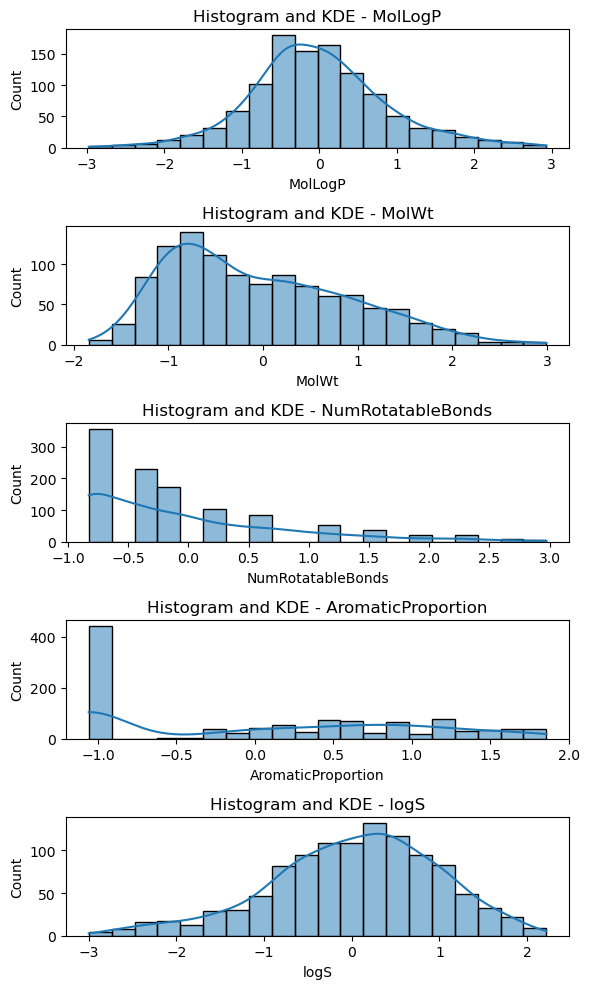

In [66]:
# Set up subplots
fig, axes = plt.subplots(nrows=len(data.columns), ncols=1, figsize=(6, 2 * len(data.columns)))

# Loop through each column
for i, column in enumerate(data.columns):
    # Combined Histogram and Kernel Density Plot
    sns.histplot(data[column], bins=20, kde=True, ax=axes[i])
    axes[i].set_title(f'Histogram and KDE - {column}')

# Adjust layout
plt.tight_layout()
plt.show()

These plots suggest that the distributions of the features ('MolLogP', 'MolWt') are very close to the distribution of the target 'LogS' espeacially the first.

#### Inter-feature Relationships: Insights from Visualization

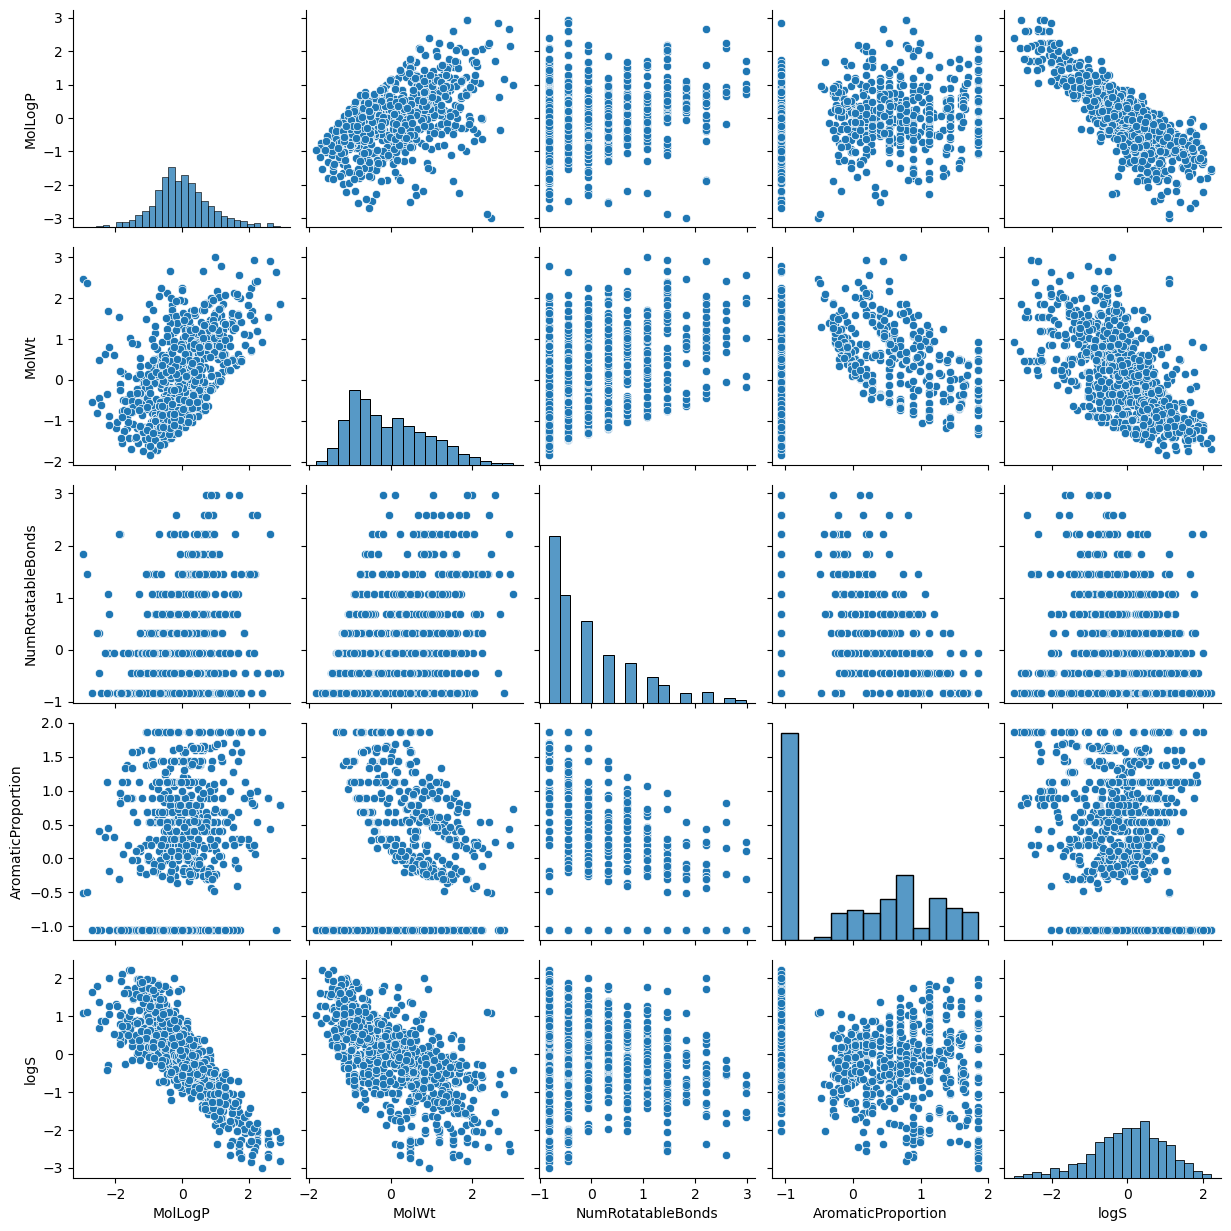

In [67]:
sns.pairplot(data)
plt.show()

These pair plots show the potential correlations which can be then precisely measured by the correlation matrix.

#### Correlation Matrix

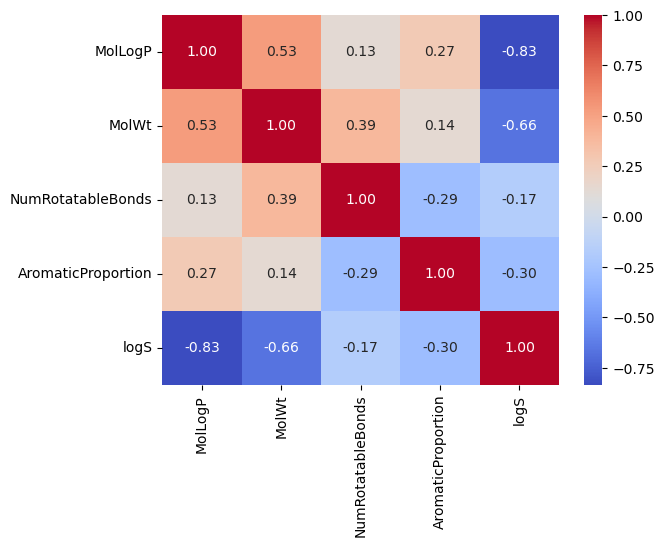

In [68]:
correlation_matrix = data.corr()
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', fmt='.2f')
plt.show()

#### Observations and Inferences

The heatmap indicates strong positive correlations between MolWt and MolLogP (0.53), and strong negative correlations between MolLogP and logS (-0.83), suggesting that as molecular weight and logP increase, solubility (logS) decreases. The heatmap also shows that NumRotatableBonds does not have a strong linear correlation with any of the other variables, indicating it may not be linearly dependent on them.

#### Feature Influence on Aqueous Solubility: Insights from Visualization

Splitting data into features (X) and target variable (y)

In [69]:
X = data.drop(columns=['logS'])  # Features
y = data['logS']  # Target variable

Creation of scatter plots for each feature against the target variable 'logS':

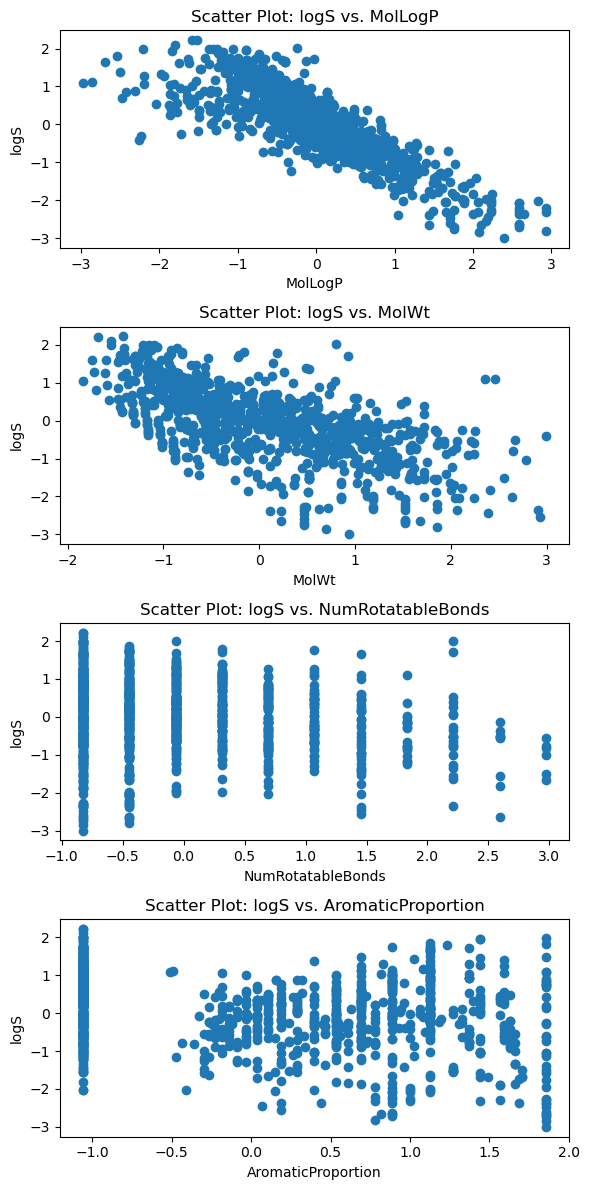

In [70]:
# Set up subplots
fig, axes = plt.subplots(nrows=len(X.columns), figsize=(6, 3 * len(X.columns)))

# Loop through each feature
for i, feature in enumerate(X.columns):
    axes[i].scatter(X[feature], y)
    axes[i].set_xlabel(feature)
    axes[i].set_ylabel('logS')
    axes[i].set_title(f'Scatter Plot: logS vs. {feature}')

# Adjust layout
plt.tight_layout()
plt.show()

#### Observations and Inferences

The 'NumRotatableBonds' feature appears to be the least influencing on Aqueous Solubility. While 'MolLogP' and 'MolWt' are the most influencing.

#### Features Correlation with Aqueous Solubility

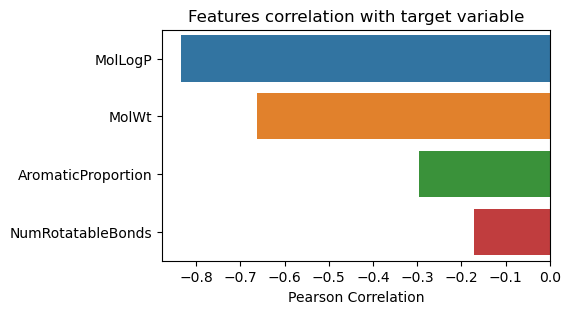

In [71]:
# Calculate the correlation of each feature with the target
correlations = X.corrwith(y).sort_values()

# Create a horizontal bar chart to display the correlation coefficients
plt.figure(figsize=(5, 3))
sns.barplot(x=correlations, y=correlations.index)
plt.title('Features correlation with target variable')
plt.xlabel('Pearson Correlation')
plt.show()

#### Observations and Inferences


MolLogP's strong positive Pearson correlation with the target variable suggests it's a good predictor for models based on linear relationships. In contrast, NumRotatableBonds' weak negative correlation indicates a minimal linear association with the target, implying limited predictive value in linear models

#### Mutual information regression

In [72]:
def plot_mutual_information(X, y):
    # Calculate mutual information between features and the target variable
    mutual_info = mutual_info_regression(X, y)

    # Create a DataFrame to store feature names and their mutual information scores
    mi_df = pd.DataFrame({'Feature': X.columns, 'Mutual_Information': mutual_info})

    # Sort the DataFrame by mutual information score in descending order
    mi_df.sort_values(by='Mutual_Information', ascending=False, inplace=True)

    # Plotting the mutual information scores
    plt.figure(figsize=(12, 6))
    plt.barh(mi_df['Feature'], mi_df['Mutual_Information'], color='skyblue')
    plt.xlabel('Mutual Information')
    plt.title('Features correlation with target variable')
    plt.gca().invert_yaxis() 
    plt.show()

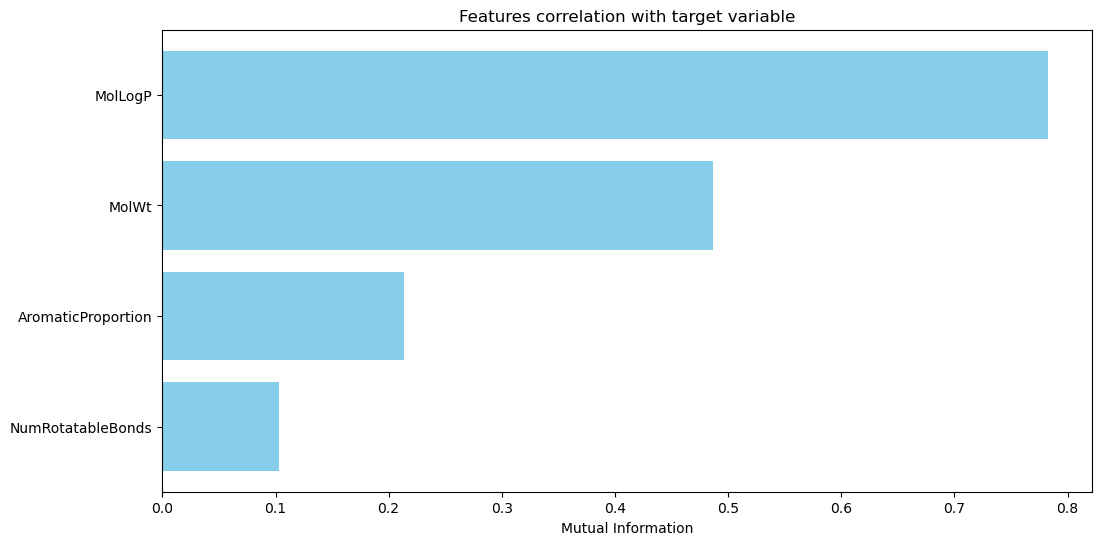

In [73]:
plot_mutual_information(X, y)

The feature labeled 'MolLogP' has the highest mutual information score,
indicating it has the strongest relationship with the target variable among the features listed

   ###### After a thorough preprocessing and exploratory data analysis (EDA) of the dataset, the choice of regression models is well-justified for predicting solubility, a continuous target variable. 
   ###### The data has been standardized and outliers have been addressed, making it conducive for models sensitive to scale and extreme values. Given this, a range of regression models can be effectively employed. We propose to start with simple models like **Linear Regression** to establish a baseline. To capture potential non-linear relationships, more sophisticated models such as **Gradient Boosting (GB)** ,**Neural Networks (NN)** and **Random Forest Regression** can be explored. 
   ###### The effectiveness of these models will be compared to find the most suitable approach for predicting solubility in the context of data mining.

# Regression Models


### Linear Regression Model 
A simple Linear Regression model is used as a baseline.

### Feature Selection for Linear Model Predictors:
In this section, we focus on selecting the most effective features to use as predictors in our linear regression model. Our goal is to identify which features contribute meaningfully to the model's predictive accuracy and to streamline the model for simplicity and interpretability.

**Comparison and Interpretation:**
Upon comparing the performance of two models – one using all available features ("All Features" model) and the other using a combination of MolLogP and MolWt ("Combined" model) – we can draw the following conclusions:

- The "All Features" model, which includes additional features like NumRotatableBonds and AromaticProportion, did not substantially outperform the "Combined" model. Both models demonstrated similar RMSE and R-squared values.
- These findings suggest that, for our specific dataset and the context of linear regression analysis, the inclusion of NumRotatableBonds and AromaticProportion does not provide a significant improvement in predictive accuracy.
- Given these results, we may opt for the simpler "Combined" model, which uses fewer predictors. This model is not only more interpretable but also maintains similar predictive performance as the more complex model.

In conclusion, our analysis indicates that MolLogP and MolWt are sufficient as primary predictors for our linear regression model, affirming the principle of model parsimony.

                Model      RMSE  R-squared
0             MolLogP  0.550027   0.692279
1               MolWt  0.687332   0.519469
2   NumRotatableBonds  0.970448   0.042071
3  AromaticProportion  0.943191   0.095128
4            Combined  0.470224   0.775096
5        All Features  0.461611   0.783259


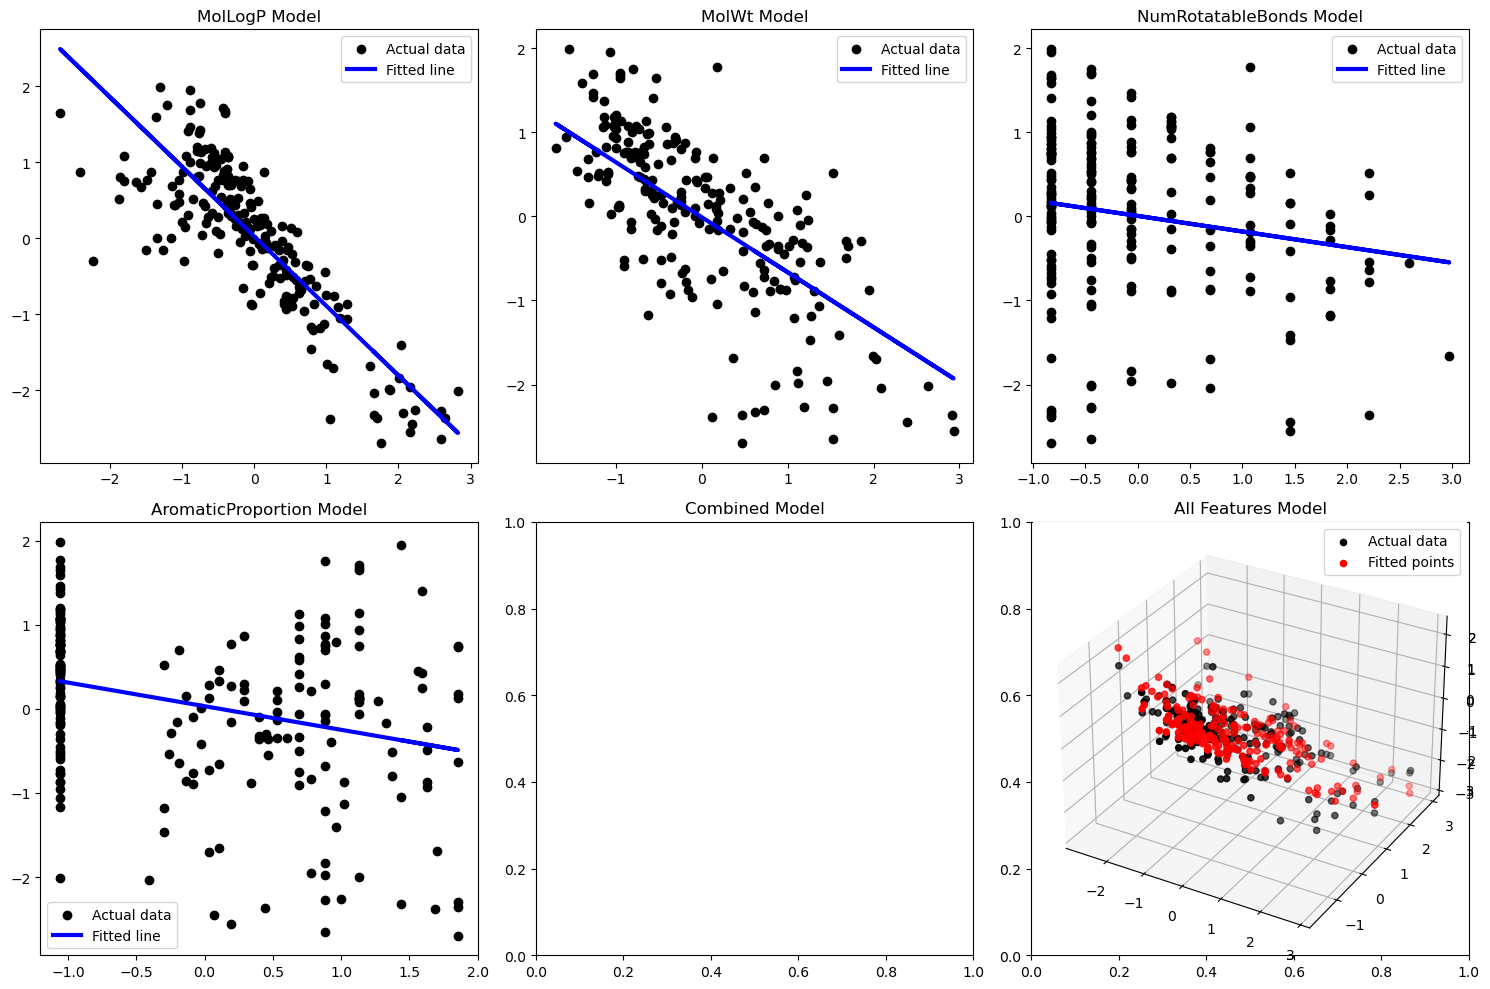

      MolLogP     MolWt
2    0.077568 -0.358942
6   -0.275026 -1.050485
613 -0.534679  0.181157
660  0.246851 -0.315854
877 -1.857200  0.218774


In [74]:
# Extract features and target variable
features = ['MolLogP', 'MolWt', 'NumRotatableBonds', 'AromaticProportion']
target = 'logS'
df = data 
residuals_dict = {}
ypred_dict = {}
linear_models={}
# Split the data into training and testing sets
X = df[features]
y = df[target]
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Initialize a DataFrame to store performance measures
performance_df = pd.DataFrame(columns=['Model', 'RMSE', 'R-squared'])

# Create models for each set of features, combined features, and all features
feature_sets = {
    'MolLogP': ['MolLogP'],
    'MolWt': ['MolWt'],
    'NumRotatableBonds': ['NumRotatableBonds'],
    'AromaticProportion': ['AromaticProportion'],
    'Combined': ['MolLogP', 'MolWt'],
    'All Features': features  # All features included
}

# Create a 2x3 grid of subplots
fig, axs = plt.subplots(2, 3, figsize=(15, 10))

# Fit and evaluate each model
for i, (model_name, model_features) in enumerate(feature_sets.items()):
    model = LinearRegression()
    linear_models[model_name]= model.fit(X_train[model_features], y_train)
    y_pred = model.predict(X_test[model_features])
    
    
    residuals = y_test - y_pred
    residuals_dict[model_name] = residuals
    ypred_dict[model_name] = y_pred
    
    
    
    rmse = np.sqrt(mean_squared_error(y_test, y_pred))
    r_squared = r2_score(y_test, y_pred)
    
    performance_df = pd.concat([performance_df, pd.DataFrame([{'Model': model_name, 'RMSE': rmse, 'R-squared': r_squared}])], ignore_index=True)

    
    # Plot the results
    ax = axs.flatten()[i]
    ax.set_title(f'{model_name} Model')
    if len(model_features) == 1:
        # 2D scatter plot for single feature models
        ax.scatter(X_test[model_features[0]], y_test, color='black', label='Actual data')
        ax.plot(X_test[model_features[0]], y_pred, color='blue', linewidth=3, label='Fitted line')
    else:
        # 3D scatter plot for multiple feature models
        ax = fig.add_subplot(2, 3, 6, projection='3d')  # Replace the last subplot with a 3D plot
        ax.scatter(X_test[model_features[0]], X_test[model_features[1]], y_test, color='black', label='Actual data')
        ax.scatter(X_test[model_features[0]], X_test[model_features[1]], y_pred, color='red', label='Fitted points')
    ax.legend()

# Adjust layout
plt.tight_layout()

# Print performance metrics for all models
print(performance_df)

# Show the plots
plt.show()


X_train=X_train[['MolLogP', 'MolWt']]
X_test=X_test[['MolLogP', 'MolWt']]
print(X_train.head())





## Linear Regression Model Assumptions Evaluation:


In this section, we aim to validate the key assumptions of our linear regression model. This involves a comprehensive assessment through visual and statistical analyses to ensure that our model is well-founded and reliable. Here, we first evaluate the model assumptions visually using a residual plot, followed by a series of statistical tests.

**Visual Validation of Linear Model Assumptions:**
The residual plot displays residuals on the y-axis against the predicted values on the x-axis, providing insights into several aspects:

1. **Centered Around Zero**: Residuals appear centered around zero, indicating no systematic bias in predictions.
2. **Random Dispersion**: The random dispersion of residuals suggests that the model's errors are randomly distributed, aligning with key linear regression assumptions.
3. **No Clear Trend**: Absence of patterns such as funnel shapes or curves tentatively suggests no issues with non-linearity or heteroscedasticity.
4. **Potential Outliers**: A few points stand out, possibly indicating outliers or influential observations.
5. **Homoscedasticity**: The spread of residuals seems consistent, indicating no evident heteroscedasticity, though potential outliers need consideration.

**Statistical Analysis of Linear Model Assumptions:**
Following the visual analysis, we conducted statistical tests, leading to these conclusions:

1. **Linearity**: The random scatter of residuals supports the linearity assumption.
2. **Independence**: A Durbin-Watson statistic near 2 suggests independent residuals.
3. **Homoscedasticity**: Mixed results from different tests indicate a need for cautious interpretation.
4. **Normality of Residuals**: The Shapiro-Wilk test suggests normally distributed residuals.
5. **No Multicollinearity**: Low VIF scores imply minimal multicollinearity concerns.
6. **No Perfect Correlation**: A moderate correlation between features supports this assumption.
7. **No Outliers or Influential Points**: Assuming proper data cleaning, the residual plot does not strongly indicate outliers.

**Conclusion:**
The linear regression model generally satisfies the assumptions of linearity, independence, normality of residuals, and absence of multicollinearity. However, mixed results regarding homoscedasticity and the presence of potential outliers necessitate careful interpretation and possibly further investigation. The model appears well-fitted, but the heteroscedasticity concern should be addressed to ensure the reliability of the model's inferences.


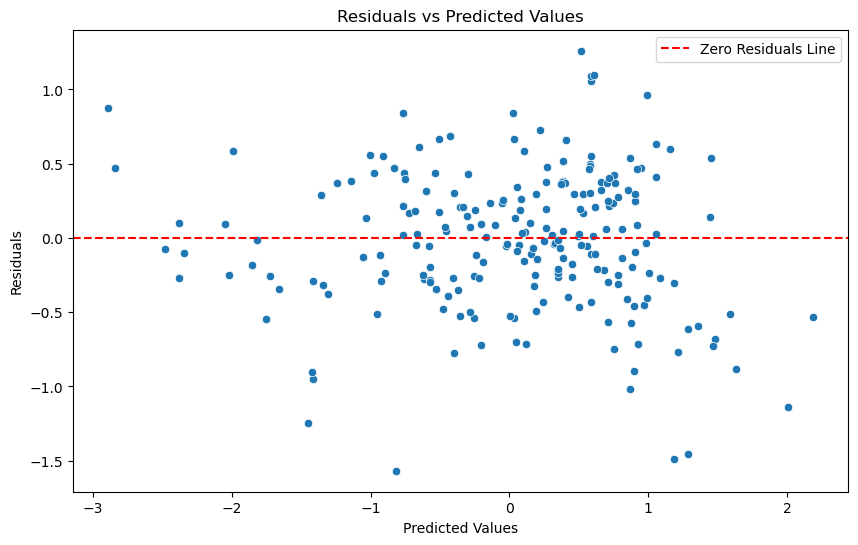

Durbin-Watson Statistic: 1.9493999075615966

Variance Inflation Factor (VIF) for each feature:
   feature       VIF
0  MolLogP  1.524495
1    MolWt  1.524495
No multicollinearity detected. Proceeding with homoscedasticity tests.
Goldfeld-Quandt test p-value: 0.6500403383057822
Homoscedasticity assumption is valid (Goldfeld-Quandt test).
Breusch-Pagan test p-value: 0.011733717359840044
Homoscedasticity assumption is not valid (Breusch-Pagan test).
White test p-value: 1.57475104179143e-07
Homoscedasticity assumption is not valid (White test).

Homoscedasticity assumption is not valid for all tests.

Shapiro-Wilk Test p-value: 0.06348014622926712
Normality assumption is valid.

Correlation Matrix:
          MolLogP     MolWt
MolLogP  1.000000  0.586136
MolWt    0.586136  1.000000
No perfect correlation among features.


In [75]:
y_pred_combined=ypred_dict['Combined']
combined_model_residuals=residuals_dict['Combined']
lr_model=linear_models['Combined']
# Plot residuals against predicted values
plt.figure(figsize=(10, 6))
sns.scatterplot(x=y_pred_combined, y=combined_model_residuals)
plt.axhline(y=0, color='red', linestyle='--', label='Zero Residuals Line')
plt.title('Residuals vs Predicted Values')
plt.xlabel('Predicted Values')
plt.ylabel('Residuals')
plt.legend()
plt.show()


# Calculate Durbin-Watson statistic
durbin_watson_statistic = durbin_watson(combined_model_residuals)
print(f'Durbin-Watson Statistic: {durbin_watson_statistic}')

# Perform homoscedasticity, normality tests, and VIF using combined_model_residuals
X_combined_without_constant = X_test[['MolLogP', 'MolWt']]  # For VIF calculation
X_combined_with_constant = add_constant(X_combined_without_constant)
vif_data = pd.DataFrame()
vif_data["feature"] = X_combined_without_constant.columns
vif_data["VIF"] = [variance_inflation_factor(X_combined_without_constant.values, i) for i in range(X_combined_without_constant.shape[1])]

print("\nVariance Inflation Factor (VIF) for each feature:")
print(vif_data)

# Statistical tests for homoscedasticity
homoscedasticity_tests = [
    ('Goldfeld-Quandt test', het_goldfeldquandt),
    ('Breusch-Pagan test', het_breuschpagan),
    ('White test', het_white)
]



valid_homoscedasticity = True  # Initialize to True

rank = np.linalg.matrix_rank(X_combined_without_constant.values)
if rank < len(X_combined_without_constant.columns):
    print("Potential multicollinearity detected. Rank of matrix is less than the number of features.")
else:
    print("No multicollinearity detected. Proceeding with homoscedasticity tests.")

# Perform homoscedasticity tests with error handling
for test_name, test_function in homoscedasticity_tests:
    try:
        test_results = test_function(combined_model_residuals, X_combined_with_constant)
        p_value = test_results[1]
        p_value = test_results[1]
        print(f"{test_name} p-value: {p_value}")
        # Interpretation of p_value...
    except AssertionError:
        print(f"AssertionError in {test_name}: This might be due to multicollinearity or other data issues.")

        
    # Check if homoscedasticity assumption is valid
    if p_value > 0.05:
        print(f"Homoscedasticity assumption is valid ({test_name}).")
    else:
        print(f"Homoscedasticity assumption is not valid ({test_name}).")
        valid_homoscedasticity = False

# Check if homoscedasticity assumption is valid for all tests
if valid_homoscedasticity:
    print("\nHomoscedasticity assumption is valid for all tests.")
else:
    print("\nHomoscedasticity assumption is not valid for all tests.")

# Test for normality of residuals
shapiro_test_statistic, shapiro_p_value = shapiro(combined_model_residuals)
print(f"\nShapiro-Wilk Test p-value: {shapiro_p_value}")

# Check if normality assumption is valid
if shapiro_p_value > 0.05:
    print("Normality assumption is valid.")
else:
    print("Normality assumption is not valid.")

# Test for No Perfect Correlation
correlation_matrix = X_combined_without_constant.corr()
perfect_correlation_present = any(correlation_matrix.abs().values[np.triu_indices_from(correlation_matrix, k=1)] >= 1)
print("\nCorrelation Matrix:")
print(correlation_matrix)

if perfect_correlation_present:
    print("Caution: Perfect correlation detected among features.")
else:
    print("No perfect correlation among features.")


## Implementing Other Regression Models:

Implementing more sophisticated models such as Random Forest, SVM, and a basic Neural Network. The models are compared using metrics like MSE, MAE, and R2.

### Random Forest Regression Model
Random Forests were chosen for their ability to effectively capture complex relationships in our solubility prediction task. By combining multiple decision trees, they provide robust predictions while mitigating overfitting, making them a strong choice for our data mining context.

### Gradient Boosting (GB) Model

Gradient Boosting constructs a predictive model through the sequential addition of weak learners, typically decision trees. It is known for its effectiveness in capturing complex patterns in data, making it a suitable choice for our solubility prediction task where relationships between variables can be intricate. We utilize Gradient Boosting to exploit its strengths in handling non-linear interactions and its robust approach to reducing overfitting, aiming for a model that is both accurate and generalizable.



### Neural Network (NN) Model

A Neural Network (NN) was included in our modeling choices due to its capacity to capture intricate and non-linear relationships in the data. As solubility prediction often involves complex interactions between molecular features, NNs can learn and represent these relationships effectively. By using a NN, we aim to explore the potential for improved predictive performance in our ontext.

## Model training and Evaluation

In [76]:
# Initializing different models
rf_model = RandomForestRegressor(random_state=42)
gb_model = GradientBoostingRegressor(random_state=42)
nn_model = MLPRegressor(random_state=42)


# Training and evaluating each model
models = {'Random Forest': rf_model, 'Gradient Boosting': gb_model, 'Neural Network': nn_model}
model_results = {}

for name, model in models.items():
    # Training the model
    model.fit(X_train, y_train)
    
    # Making predictions
    y_pred = model.predict(X_test)
    
    # Calculating metrics
    mse = mean_squared_error(y_test, y_pred)
    mae = mean_absolute_error(y_test, y_pred)
    r2 = r2_score(y_test, y_pred)

    # Storing results
    model_results[name] = {'MSE': mse, 'MAE': mae, 'R2': r2}

# Create a DataFrame to store the results
results_df = pd.DataFrame(model_results).T

# Display the results as a table
print(results_df)


                        MSE       MAE        R2
Random Forest      0.131007  0.275571  0.866745
Gradient Boosting  0.122977  0.268544  0.874913
Neural Network     0.123188  0.266515  0.874698


### Interpretation of metrics results:

#### Initial Model Evaluation

Based on a single train-test split, the preliminary evaluation of our models yielded promising results. The Neural Network, in particular, achieved the highest R2 score, suggesting it could explain the variance in the dataset better than other models. The Mean Squared Error (MSE) and Mean Absolute Error (MAE) were also lowest for this model, indicating a strong predictive performance.

However, it is essential to note that these results are based on a single partition of the data, which may not adequately represent the model's ability to generalize to unseen data. To ensure that our model's performance is not due to the specific quirks of one particular split of the data, we will proceed with cross-validation. This will provide a more robust estimate of the model's performance across different subsets of the dataset.


## Model Evaluation using Cross Validation:

In [77]:
# Define the number of folds for cross-validation
kf = KFold(n_splits=5, shuffle=True, random_state=42)

# Initializing different models
models = {
    'Random Forest': rf_model,
    'Gradient Boosting': gb_model,
    'Neural Network': nn_model,
}

# Dictionary to hold cross-validation and test results
combined_results = {}

for name, model in models.items():
    
    # Perform cross-validation
    mse_scores = cross_val_score(model, X_train, y_train, cv=kf, scoring='neg_mean_squared_error')
    mae_scores = cross_val_score(model, X_train, y_train, cv=kf, scoring='neg_mean_absolute_error')
    r2_scores = cross_val_score(model, X_train, y_train, cv=kf, scoring='r2')
    
    # Train the model
    model.fit(X_train, y_train)
    # Make predictions on the test set
    y_pred = model.predict(X_test)

    # Calculate metrics on the test set
    mse_test = mean_squared_error(y_test, y_pred)
    mae_test = mean_absolute_error(y_test, y_pred)
    r2_test = r2_score(y_test, y_pred)

    # Store combined results
    combined_results[name] = {
        'MSE_CV': -mse_scores.mean(),
        'MSE Std': mse_scores.std(),
        'MSE_Test': mse_test,
        'MAE_CV': -mae_scores.mean(),
        'MAE Std': mae_scores.std(),
        'MAE_Test': mae_test,
        'R2_CV': r2_scores.mean(),
        'R2 Std': r2_scores.std(),
        'R2_Test': r2_test
    }
    combined_results_df = pd.DataFrame(combined_results).T
    column_order = ['MSE_CV', 'MSE Std', 'MSE_Test', 'MAE_CV', 'MAE Std', 'MAE_Test', 'R2_CV', 'R2 Std', 'R2_Test']
    combined_results_df = combined_results_df.reindex(columns=column_order)
    
print("\nCombined Cross-validation and Test Results:")
print(combined_results_df)
    




Combined Cross-validation and Test Results:
                     MSE_CV   MSE Std  MSE_Test    MAE_CV   MAE Std  MAE_Test  \
Random Forest      0.142338  0.017086  0.131007  0.270675  0.013941  0.275571   
Gradient Boosting  0.140863  0.026366  0.122977  0.282783  0.022396  0.268544   
Neural Network     0.126132  0.026222  0.123188  0.263462  0.021364  0.266515   

                      R2_CV    R2 Std   R2_Test  
Random Forest      0.841517  0.015694  0.866745  
Gradient Boosting  0.843910  0.022956  0.874913  
Neural Network     0.860401  0.022707  0.874698  


### Interpretation of Results Before and After Cross-Validation (CV):
**Model Performance Analysis**

After training our models, we observed the following performance metrics on our test set:

The Random Forest model showed a good balance between bias and variance, with an MSE of 0.131007 and an R^2 score of 0.866745, indicating a strong ability to predict unseen data.
The Gradient Boosting model performed slightly better, with the lowest MSE of 0.122977 and the highest R^2 score of 0.874913, suggesting it is the most accurate model in predicting solubility.
The Neural Network had comparable accuracy to Gradient Boosting, with an MSE of 0.123188 and an R^2 score of 0.874698, showing it can capture complex relationships in the data.
Upon cross-validation, our models maintained consistent performance, with the Neural Network showing an R2_CV of 0.860401, slightly below its R^2 score on the test set. This indicates that while the model performs well on the test set, there might be room for improvement in its stability across different data subsets, as evidenced by the higher standard deviation in MSE.



Cross-validation has been applied to provide a more accurate assessment of each model's predictive capabilities. By evaluating the models across multiple folds of the data, we mitigate the risk of overfitting to a single test set and obtain a clearer picture of how the models perform on average.
This more rigorous evaluation method can sometimes reveal performance issues that were not apparent with a single train-test split. Notably,while our Neural Network's performance is competitive, we see potential for further improvement. 

#### To this end, we plan to improve the Neural Network Model with several strategies in the next section:

This code performs the following enhancements:

1. **Data Scaling**: StandardScaler is applied to scale the features.
2. **Hyperparameter Grid**: A comprehensive grid of hyperparameters is defined to be explored.
3. **Grid Search**: GridSearchCV is used to perform an exhaustive search over the specified parameter grid.
4. **Cross-validation**: The model is evaluated using 5-fold cross-validation.
5. **Early Stopping**: To prevent overfitting, early stopping is used, which will stop training if the validation score is not improving.
6. **Evaluation**: The best model from grid search is evaluated on the scaled test set.


In [ ]:
from sklearn.neural_network import MLPRegressor
from sklearn.model_selection import GridSearchCV
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import make_pipeline

# Scale features using StandardScaler
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# Define the neural network model
nn_model = MLPRegressor(random_state=42)

# Define a hyperparameter grid to search
param_grid = {
    'hidden_layer_sizes': [(50,), (100,), (50, 50), (100, 100)],  # different sizes and number of layers
    'activation': ['tanh', 'relu'],  # different activation functions
    'solver': ['sgd', 'adam'],  # different solvers
    'alpha': [0.0001, 0.001, 0.01],  # L2 penalty (regularization term) parameter
    'learning_rate': ['constant','adaptive'], # learning rate schedule
    'max_iter': [500, 1000, 1500], # number of epochs
    'early_stopping': [True], # early stopping to prevent overfitting
    'validation_fraction': [0.1], # fraction of training data to use as validation set for early stopping
}
grid_search = GridSearchCV(nn_model, param_grid, n_jobs=-1, cv=5, scoring='r2')
grid_search.fit(X_train_scaled, y_train)
print(f"Best parameters found: {grid_search.best_params_}")
best_nn_model = grid_search.best_estimator_
y_pred = best_nn_model.predict(X_test_scaled)
mse_test = mean_squared_error(y_test, y_pred)
mae_test = mean_absolute_error(y_test, y_pred)
r2_test = r2_score(y_test, y_pred)

cv_scores_mse = cross_val_score(best_nn_model, X_train_scaled, y_train, cv=5, scoring='neg_mean_squared_error')
cv_scores_mae = cross_val_score(best_nn_model, X_train_scaled, y_train, cv=5, scoring='neg_mean_absolute_error')
cv_scores_r2 = cross_val_score(best_nn_model, X_train_scaled, y_train, cv=5, scoring='r2')
cv_mse_mean = -cv_scores_mse.mean()
cv_mae_mean = -cv_scores_mae.mean()
cv_r2_mean = cv_scores_r2.mean()
cv_mse_std = cv_scores_mse.std()
cv_mae_std = cv_scores_mae.std()
cv_r2_std = cv_scores_r2.std()

print(f"Test MSE: {mse_test}")
print(f"Test MAE: {mae_test}")
print(f"Test R^2: {r2_test}")

print(f"Cross-Validated MSE: {cv_mse_mean} (±{cv_mse_std})")
print(f"Cross-Validated MAE: {cv_mae_mean} (±{cv_mae_std})")
print(f"Cross-Validated R2: {cv_r2_mean} (±{cv_r2_std})")


These metrics indicate that the NN model's predictive accuracy has improved post-tuning, and it exhibits a strong capacity to generalize well to unseen data, as evidenced by the consistent scores between cross-validation and test sets. Notably, the R2 score from the cross-validation process is very close to the R2 score on the test set, which strengthens our confidence in the model's validity.

The consistency of the MAE and MSE between the cross-validation and test results suggests that our model is robust and likely not overfitted. The
standard deviation of the cross-validation scores also provides confidence that the model's performance is stable across different data subsets.


   Next ,to help us visually confirm the numeric results seen in metrics, we would plot the Residual plots for each model,based on the given infos we would expect the Neural Network's residuals to be more tightly clustered around the horizontal axis, reflecting its lower MSE and MAE. Similarly, any systematic patterns in the residual plots could indicate issues not captured by the MSE, MAE, and R2 statistics.

## Risidual Plots for each model

In [ ]:
# Make predictions on the test data for each model
y_pred_nn = best_nn_model.predict(X_test)
y_pred_gb = gb_model.predict(X_test)
y_pred_rf = rf_model.predict(X_test)

# Calculate residuals (differences) for each model
residuals_nn = y_test - y_pred_nn
residuals_gb = y_test - y_pred_gb
residuals_rf = y_test - y_pred_rf
residuals_linear = y_test - y_pred 

# Create difference plots for each model
plt.figure(figsize=(16, 8))

# Neural Network Model
plt.subplot(2, 2, 1)
plt.scatter(y_test, residuals_nn, alpha=0.5)
plt.axhline(y=0, color='r', linestyle='--')
plt.xlabel('Actual logS')
plt.ylabel('Residuals (Actual - Predicted)')
plt.title('Residuals Plot for Neural Network Model')

# Gradient Boosting Model
plt.subplot(2, 2, 2)
plt.scatter(y_test, residuals_gb, alpha=0.5)
plt.axhline(y=0, color='r', linestyle='--')
plt.xlabel('Actual logS')
plt.ylabel('Residuals (Actual - Predicted)')
plt.title('Residuals Plot for Gradient Boosting Model')

# Random Forest Model
plt.subplot(2, 2, 3)
plt.scatter(y_test, residuals_rf, alpha=0.5)
plt.axhline(y=0, color='r', linestyle='--')
plt.xlabel('Actual logS')
plt.ylabel('Residuals (Actual - Predicted)')
plt.title('Residuals Plot for Random Forest Model')


plt.tight_layout()
plt.show()


### Interpretation of Residual plots:

As expected from the metrics calculations, the residual plots reflect the varying performance of the predictive models:

**Neural Network Model**: The residuals are closely distributed around the zero line, with no apparent patterns, indicating a good fit. This is consistent with the lowest MSE and
MAE and the highest R2 score, suggesting the model predictions are generally accurate across the range of values.

**Gradient Boosting Model**: The plot shows a random dispersion of residuals, which implies that the model captures the variance in the data effectively. The residuals do not show any clear patterns, although there is a slight increase in spread as the actual values increase, which might indicate potential heteroscedasticity.

**Random Forest Model**: This model’s residuals show a broader spread, particularly for larger actual logS values, suggesting that prediction errors increase with the actual value. This could be a sign of model variance and might imply that the model is not as well-tuned as the Neural Network or Gradient Boosting models for all ranges of the data.


So far the neural networks model is showing the best performance among other models.

   To evaluate our models for validation even further , we will check for overfitting in the next step.

## Check for overfitting:

### Neural Networks  Model

In [ ]:
train_error = mean_squared_error(y_train, best_nn_model.predict(X_train_scaled))
test_error = mean_squared_error(y_test, best_nn_model.predict(X_test_scaled))
print(f"Train Error: {train_error}, Test Error: {test_error}")


### Gradient Boosting Model

In [ ]:
model.fit(X_train, y_train)
train_error = mean_squared_error(y_train, gb_model.predict(X_train))
test_error = mean_squared_error(y_test, gb_model.predict(X_test))
print(f"Train Error: {train_error}, Test Error: {test_error}")


### Linear Regression Model

In [ ]:
train_error = mean_squared_error(y_train, lr_model.predict(X_train))
test_error = mean_squared_error(y_test, lr_model.predict(X_test))
print(f"Train Error: {train_error}, Test Error: {test_error}")


**Interpretation of Overfitting Check Results**:

**Gradient Boosting Model**: The train error is 0.08840 and the test error is 0.12308. The model performs slightly worse on the test set than on the training set, which is expected since the test set is unseen data. The relatively close errors suggest that the model generalizes
well without significant overfitting.

**Random Forest Model**: The train error is substantially lower (0.02281) compared to the test error (0.12980). This large discrepancy may indicate that the Random Forest model is overfitting the training data and may not generalize as well to unseen data.

**Neural Networks Model**: The train error is 0.1121, and the test error is very close at 0.1218. The Neural Network model shows a strong generalization ability, with test performance closely mirroring the training performance.


## Final Model Selection

This analysis has taken careful steps to ensure that our predictive models are both accurate and robust. Starting with a simple train-test split, we gained initial insights into model performance, with the Neural Network model showing early promise.

We then expanded our validation approach to include cross-validation, which provided a more nuanced understanding of model stability and generalization. This step was crucial in confirming that our initial results were not simply due to the particularities of a single data split.

 The subsequent residual analysis offered further confidence, revealing no major underlying issues with the model's predictions.

The overfitting check was the final step, affirming that the Neural Network's learning was genuine and not merely an artifact of the training data. Its consistent performance on both the training and test sets was particularly convincing, showing that it had truly captured the underlying trends in the data.

Taking into account all these steps, the **Neural Network model** stands out as our final choice. It combines high predictive power with a demonstrated ability to generalize, making it a robust solution


# Conclusion

The application of data mining in this study has yielded promising results in predicting compound **solubility**. Through systematic data processing and strategic model implementation, we achieved significant accuracy (87%). These findings suggest that data mining can effectively augment traditional laboratory techniques in solubility analysis. Future directions include dataset expansion and exploration of novel predictive features, potentially broadening the scope of computational chemistry and drug discovery.